In [1]:
import os
import nltk
import sys
#Open Download Editor
#nltk.download()

import ssl
nltk.download("stopwords") 
import numpy as np
import json
import glob
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import nbformat
warnings.filterwarnings("ignore",category=DeprecationWarning)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kylenabors/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:

#Importing Configs
# Define the path where config.py is located
#Mac
os.chdir('/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling')
#Linux
#os.chdir('/home/kwnabors/Documents/GitHub/Finance-ML-Modeling')
config_file_path = os.getcwd()
print(config_file_path)
import config

/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling
/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling
/Users/kylenabors/Documents
/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling


In [3]:
#Variables, Paramaters, and Pathnames needed for this script
database_file = config.database
database_folder = config.database_folder
bert_models = config.bert_models
bert_models_local = config.bert_models_local
keywords = config.keywords
lda_models = config.lda_models

Body = config.Body
Model = config.Model
Model_Subfolder = f'/{Body} Texts/{Model}'
texts_folder = config.texts
Model_Folder = texts_folder + Model_Subfolder


In [4]:
#Json Functions
def load_data(file):
    with open(file) as f:
        data = json.load(f)
        return data
    
def write_data(file, data):
    with open(file, 'w', encoding="utf-8") as f:
        json.dump(data, f, indent=4)

In [5]:
#Load Data
stopwords = stopwords.words('english')
#texts = load_data(f"{Model_Folder}/{Model}_texts.json")

docs = pd.read_csv(f"{Model_Folder}/{Model}_texts_long.csv") 
texts = docs['segment'].tolist()

keywords = config.keywords


In [6]:
#Remove Stopwords
def lemmatization(data, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_lg", disable=["parser", "ner"])
    texts_out = []
    for text in texts:  # unpack the sublist into text and label
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

#Lemmatize
lemmatized_texts = lemmatization(texts)


In [7]:
#Remove Stopwords
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return(final)

#Create Dictionary
data_words = gen_words(lemmatized_texts)

In [8]:
#Bigrams and Trigrams
bigrams_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=10)
trigrams_phrases = gensim.models.Phrases(bigrams_phrases[data_words], threshold=10)

bigrams = gensim.models.phrases.Phraser(bigrams_phrases)
trigram = gensim.models.phrases.Phraser(trigrams_phrases)

def make_bigrams(texts):
    return([bigrams[doc] for doc in data_words])

def make_trigram(texts):
    return([trigram[bigrams[doc]] for doc in data_words])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigram(data_bigrams)


In [9]:

#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)
texts = data_bigrams_trigrams
corpus = [id2word.doc2bow(text) for text in data_words]
tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [14]:
 #Build LDA Model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
                                           id2word=id2word,
                                           num_topics=8,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=2,
                                           iterations=50,
                                           per_word_topics=True,
                                           alpha="auto")    

lda_model.save(f'{lda_models}/{Body}/{Model}/LDA Model.model')

In [15]:

new_model = gensim.models.ldamodel.LdaModel.load(f'{lda_models}/{Body}/{Model}/LDA Model.model')
lda_model = gensim.models.ldamodel.LdaModel.load(f'{lda_models}/{Body}/{Model}/LDA Model.model')  
         
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds', R=10)
pyLDAvis.save_html(vis, f'{lda_models}/Visuals/LDA Test.html')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [16]:

from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        


/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_67386/569978413.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


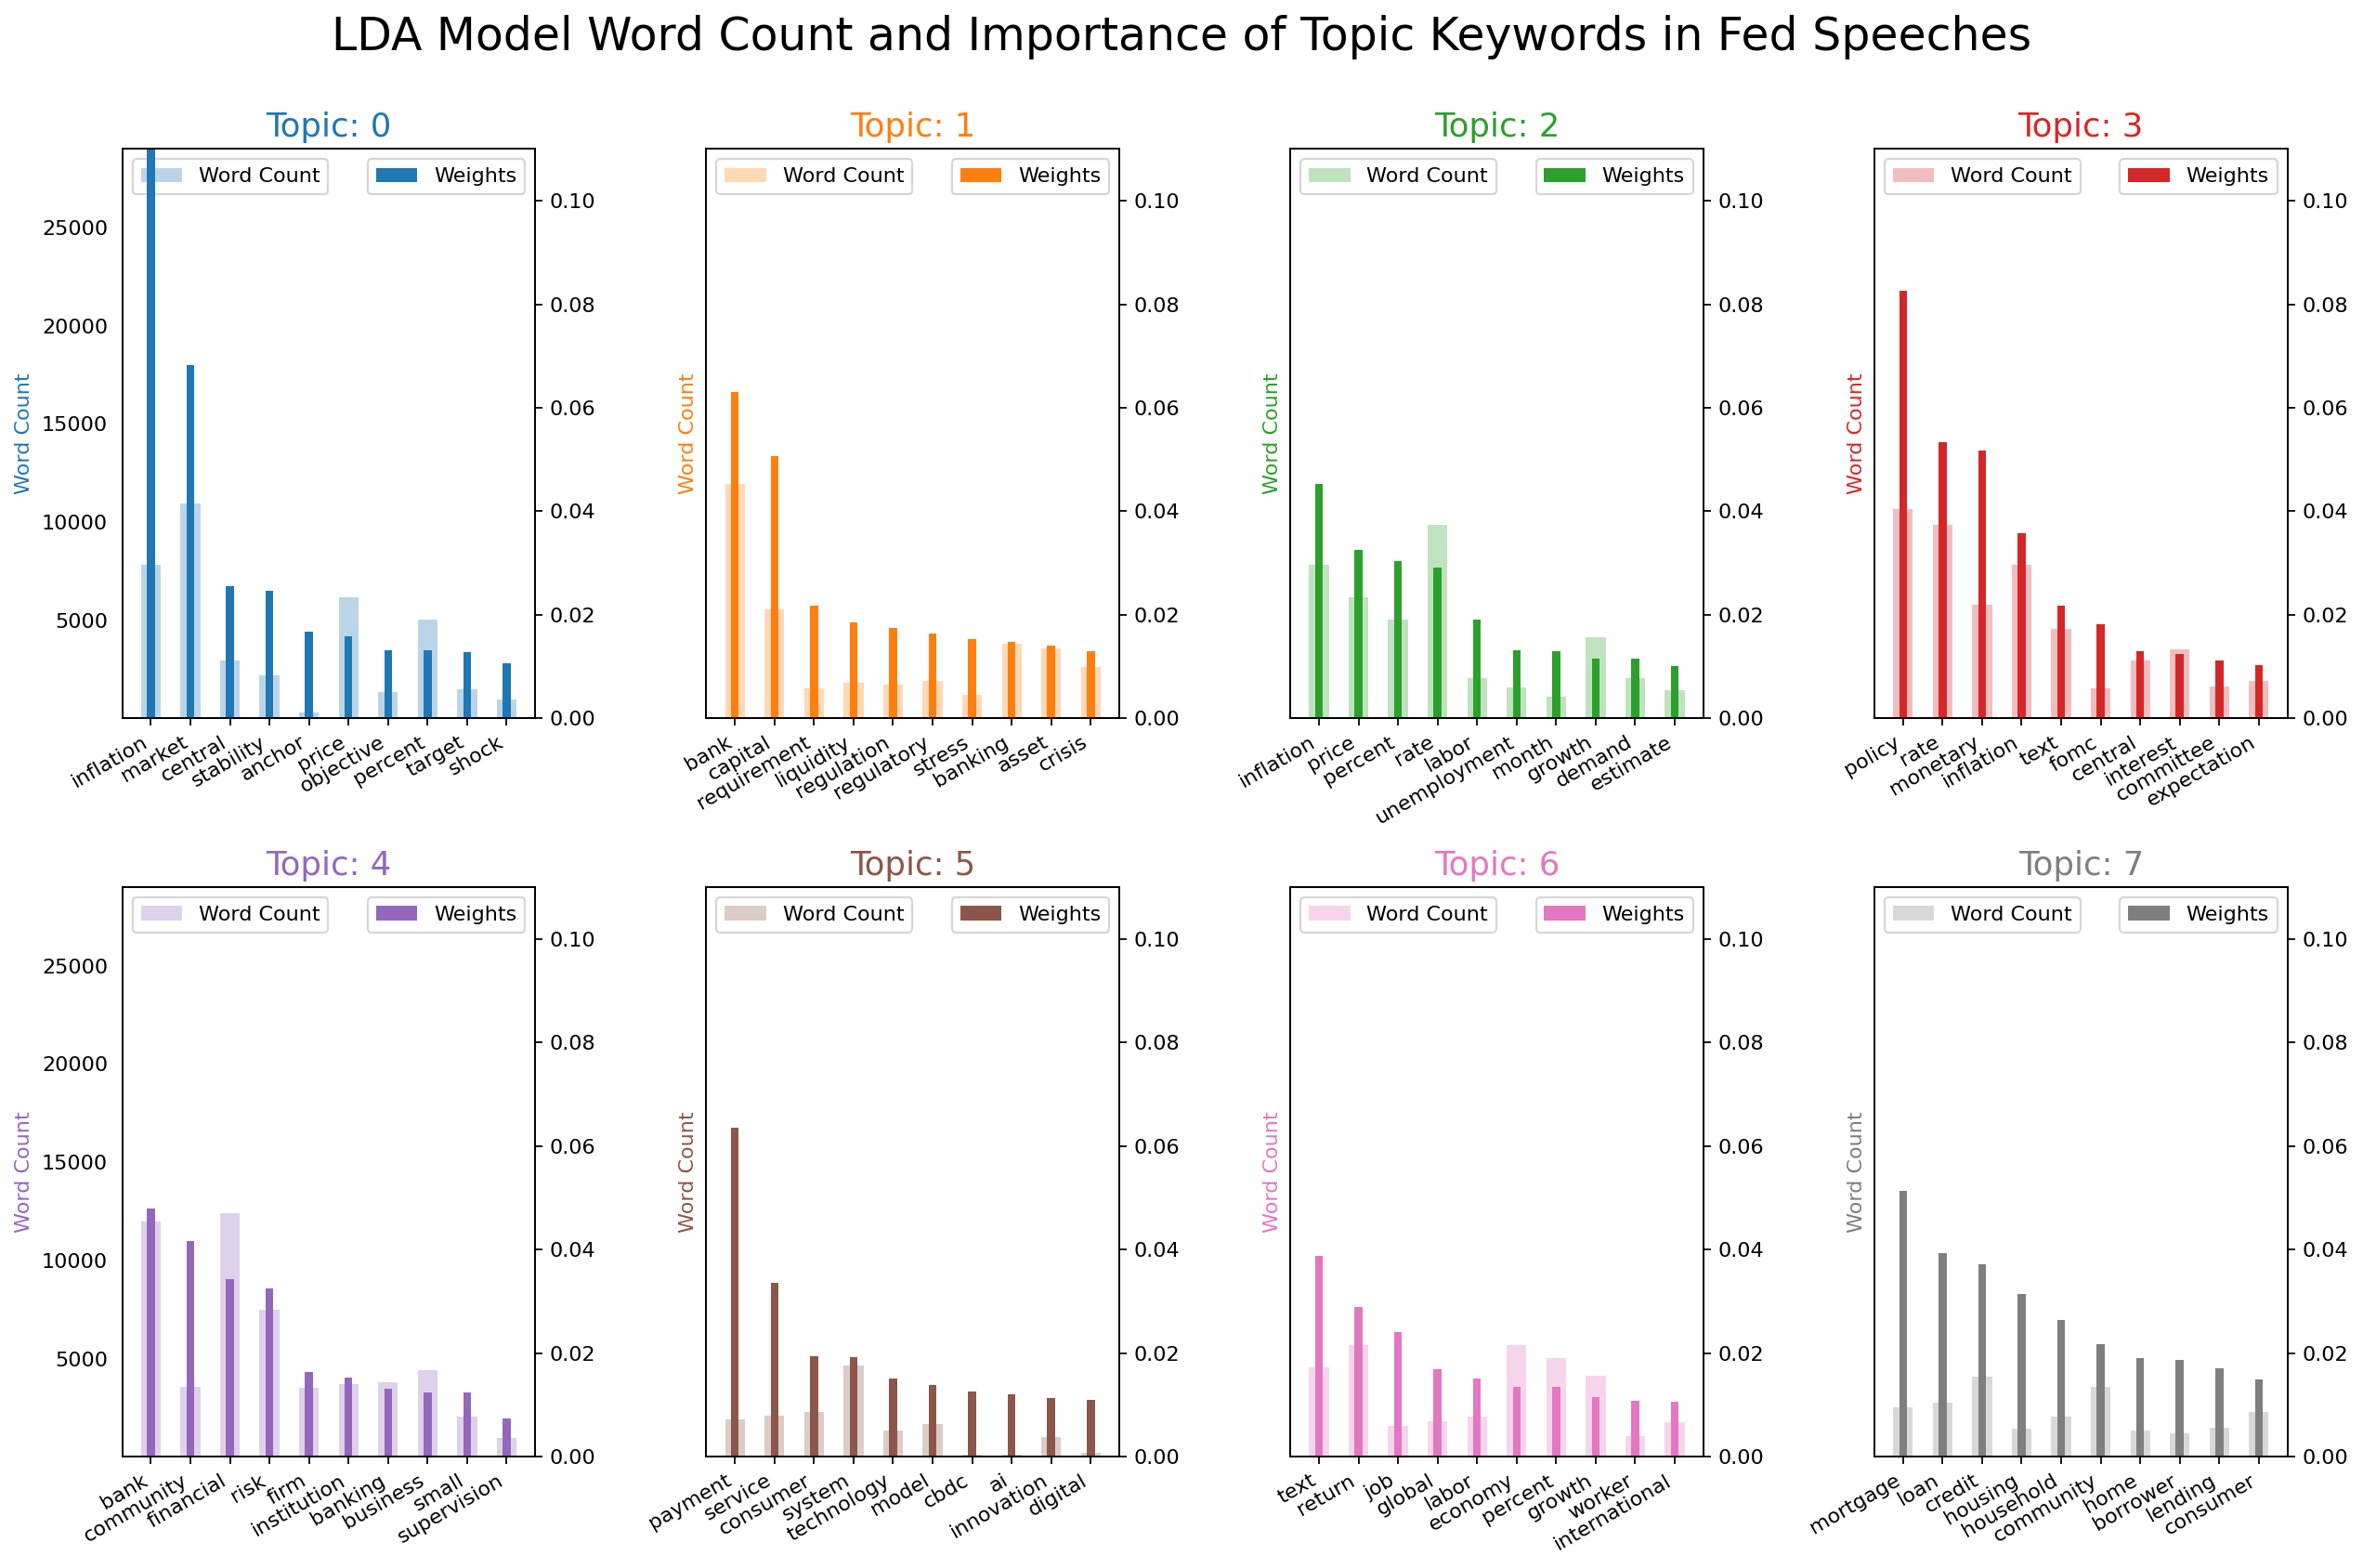

In [17]:

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 4, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    #ECB
    #ax_twin.set_ylim(0, 0.14); ax.set_ylim(10, 55000)
    #Fed
    ax_twin.set_ylim(0, 0.11); ax.set_ylim(10, 29000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle(f'LDA Model Word Count and Importance of Topic Keywords in {Body} {Model}', fontsize=22, y=1.05)    
plt.show()
#plt.savefig("/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling/Models/One Model/LDA Model.png")

